# Experiment

1. Setup dataset and dataloader
1. Setup foveation processing
1. Setup Neural Network

# Dataset and dataloader

In [1]:
import math
import numpy as np
import cv2

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# Plots

def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

def plot_images(images, num_per_row=4, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=256)
    fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    return fig

In [3]:
# Transforms

input_resize = transforms.Resize((81, 81))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
    ]
)


target_resize = transforms.Resize((81, 81), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

In [4]:
# Creating a VOC dataset without normalization for visualization.
train_dataset_viz = datasets.VOCSegmentation(
    'data',
    year='2012',
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

In [5]:
batch_size = 16
inputs, ground_truths = map(list, zip(*[train_dataset_viz[i+256+12*16] for i in range(batch_size)]))
# _ = plot_images(inputs)
# _ = plot_images(ground_truths)

# Foveated compression

In [6]:
from fovperi.fov.fov2 import getFov, reverseMapPixel, reverseMapPixel_Initial, generate_fovea 

In [7]:
# foveated_compression.py

import numpy as np
from fovperi.fov.fov2 import getFov, reverseMapPixel, reverseMapPixel_Initial, generate_fovea

class FoveatedCompression:
    def __init__(self, N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False):
        self.N = N
        self.p0 = p0
        self.Nr = Nr
        self.bio_foveation = bio_foveation
        self.add_coords = add_coords
        self.fovCenter = int((N - 2 * p0) / 2)
        self.fovSize = 2 * (p0 + Nr) + 1
        self.fovX, self.fovY = N // 2 - self.p0, N // 2 - self.p0

        # Initialize the reverse mapping and foveation functions
        self.reverseMapPixel_Initial = reverseMapPixel_Initial(N=N, p0=p0, Nr=Nr, fovCenter=self.fovCenter, bio=bio_foveation)
        self.reverseMapPixel = reverseMapPixel(N=N, p0=p0, Nr=Nr, bio=bio_foveation)
        self.getFovead = getFov(N=N, p0=p0, Nr=Nr, bio=bio_foveation, add_coords=add_coords)

    def foveated_compression(self, image):
        return np.array(self.getFovead(image, self.fovX, self.fovY, add_coords=False), dtype=np.uint8)

    def reconstruct(self, image):
        reconstructed, interpolated = self.getFovead(image, self.fovX, self.fovY, add_coords=False, reverse=True)
        return np.array(reconstructed, dtype=np.uint8), np.array(interpolated, dtype=np.uint8)


In [8]:
foveated_comp = FoveatedCompression()

In [9]:
# Test with sample image
sample_image = np.array(inputs[0], dtype=np.uint8)
sample_labels = np.array(ground_truths[0])
sample_labels = np.expand_dims(sample_labels, axis=2)

foveated_image = foveated_comp.foveated_compression(sample_image)
foveated_labels = foveated_comp.foveated_compression(sample_labels)
Image.fromarray(foveated_image)

IndexError: index 11 is out of bounds for axis 0 with size 3

In [10]:
sample_image.shape

(3, 81, 81)

In [11]:
reconstructed_image, interpolated_image = foveated_comp.reconstruct(foveated_image)
reconstructed_labels, interpolated_labels = foveated_comp.reconstruct(foveated_labels)
Image.fromarray(reconstructed_image)

NameError: name 'foveated_image' is not defined

# Neural network

In [12]:
class SqueezeMask(object):
    """Squeeze the channel dimension of the mask tensor."""
    def __call__(self, mask):
        # Assumes mask is a PyTorch tensor
        return mask.squeeze(0)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [13]:
import os
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as F

import torch

class VOCSegmentationModule(pl.LightningModule):
    def __init__(self, num_classes: int = 21, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=21, encoder_weights=None, activation=None)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.size = (64, 64)
        self.transform = transforms.Compose([transforms.Resize(self.size), transforms.ToTensor()])
        self.target_transform = transforms.Compose([transforms.Resize(self.size), transforms.ToTensor(), SqueezeMask()])

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.squeeze(1)
        outputs = self.forward(images)
        loss = self.criterion(outputs, masks.long())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.squeeze(1) 
        outputs = self.forward(images)
        loss = self.criterion(outputs, masks.long())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def train_dataloader(self):
        train_dataset = datasets.VOCSegmentation(
            root='data',
            year='2012',
            image_set='train',
            download=False,
            transform=self.transform,
            target_transform=self.target_transform
        )
        
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=0
        )
        return train_loader

    def val_dataloader(self):

        val_dataset = datasets.VOCSegmentation(
            root='data',
            year='2012',
            image_set='val',
            download=False,
            transform=self.transform,
            target_transform=self.target_transform
        )
        
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=4,
            shuffle=False,
            num_workers=0
        )
        return val_loader

# Instantiate the LightningModule
voc_module = VOCSegmentationModule()

# Setup Trainer
trainer = pl.Trainer(max_epochs=10)

# Train the model
trainer.fit(voc_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Unet             | 24.4 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\appel\anaconda3\envs\ML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
voc_module.model.eval()

image, mask = next(iter(voc_module.train_dataloader()))

In [15]:
out = voc_module.model(image)

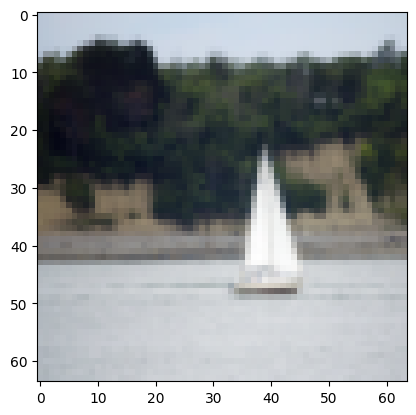

In [16]:
plt.imshow(image[0].permute(1, 2, 0))

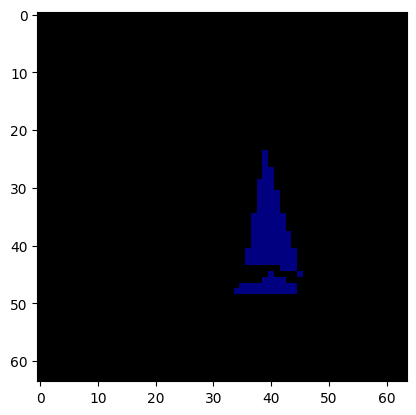

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def decode_segmap(image, nc=21):
    """
    Decode segmentation map to a RGB image, where nc is the number of classes.
    
    Args:
        image: the segmentation map (tensor or numpy array).
        nc: number of classes.
        
    Returns:
        A numpy array with the RGB representation of the segmentation map.
    """
    label_colors = np.array([
        (0, 0, 0),        # 0=background
        (128, 0, 0),      # 1=class 1
        (0, 128, 0),      # 2=class 2
        (128, 128, 0),    # 3=class 3
        (0, 0, 128),      # 4=class 4
        (128, 0, 128),    # 5=class 5
        (0, 128, 128),    # 6=class 6
        (128, 128, 128),  # 7=class 7
        (64, 0, 0),       # 8=class 8
        (192, 0, 0),      # 9=class 9
        (64, 128, 0),     # 10=class 10
        (192, 128, 0),    # 11=class 11
        (64, 0, 128),     # 12=class 12
        (192, 0, 128),    # 13=class 13
        (64, 128, 128),   # 14=class 14
        (192, 128, 128),  # 15=class 15
        (0, 64, 0),       # 16=class 16
        (128, 64, 0),     # 17=class 17
        (0, 192, 0),      # 18=class 18
        (128, 192, 0),    # 19=class 19
        (0, 64, 128),      # 20=class 20
        (224, 224, 192)   # 21=class 21
    ])

    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Assuming `output` is your model's output
# Apply softmax to get probabilities and then take the argmax across channels
segmap = mask[0]*255

# Convert the segmentation map to an RGB image
color_segmap = decode_segmap(segmap)

# Show the color segmentation map
plt.imshow(color_segmap)
plt.show()


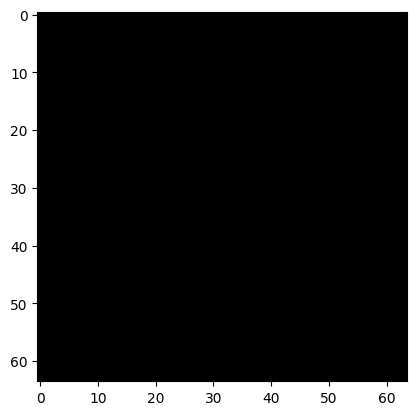

In [18]:
# Assuming `output` is your model's output
# Apply softmax to get probabilities and then take the argmax across channels
segmap = out[0][:, :, :].argmax(0)

# Convert the segmentation map to an RGB image
color_segmap = decode_segmap(segmap)

# Show the color segmentation map
plt.imshow(color_segmap)
plt.show()